In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option('display.max_columns', None)

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Класс модели Random Forest

In [3]:
# Определение класса модели Random Forest
class RandomForest():
    
    def __init__(self, n_estimators=10, min_data_in_leaf=1, max_depth=10, random_state=42, model_type='classification', split_points=-1):
        self.X_train = []                        # обучающие данные
        self.y_train = []                        # обучающие классы
        self.n_estimators = n_estimators         # кол-во решающих деревьев
        self.min_data_in_leaf = min_data_in_leaf # минимальное кол-во данных в терминаьном листе
        self.max_depth = max_depth               # максимальная глубина дерева
        self.random_state = random_state         # random_state
        self.model_type = model_type             # тип модели ('regression', 'classification')
        self.forest = []                         # Список решающих деревьев
        self.bootstrap_indexes = []              # Набор bootstrap индексов испольованных для построения деревьев
        self.split_points = split_points         # Кол-во точек разделения данных при построении ветвей (-1 - максимально возможное)
        
    # Класс узла дерева
    class Node:

        def __init__(self, index, t, left_branch, right_branch, depth=0):
            self.index = index               # индекс признака, по которому ведется сравнение с порогом в этом узле
            self.t = t                       # значение порога
            self.left_branch = left_branch   # поддерево, меньше порогового значения t (левая ветка)
            self.right_branch = right_branch # поддерево, больше порогового значения t (правая ветка)
            self.depth = depth               # глубина 
    
        # Функция предсказания для отдельного объекта
        def obj_predict(self, obj):
            if obj[self.index] <= self.t:
                return self.left_branch.obj_predict(obj)
            else:
                return self.right_branch.obj_predict(obj)
        
        def obj_predict_proba(self, obj):
            if obj[self.index] <= self.t:
                return self.left_branch.obj_predict_proba(obj)
            else:
                return self.right_branch.obj_predict_proba(obj)         
        
        # Функция формирования предсказания по выборке на одном дереве
        def predict(self, data):
            return np.array([self.obj_predict(obj) for obj in np.array(data)])
                
        def predict_proba(self, data):          
            return np.array([self.obj_predict_proba(obj) for obj in np.array(data)])
        
    
    # Класс терминального листа
    class Leaf:
        def __init__(self, data, labels, depth, model_type):
            self.data = data
            self.labels = labels
            self.depth = depth
            self.model_type = model_type # тип предсказания 'Classificator', 'Regressor'
            self.prediction = self.obj_predict()
        
        def obj_predict(self, obj=None):
            if self.model_type == 'classification':
                return max(set(self.labels), key=list(self.labels).count)
            if self.model_type == 'regression':
                return np.mean(self.labels)
            
            return np.zeros(len(self.labels))
        
        def obj_predict_proba(self, obj=None):
            if self.model_type == 'classification':
                return max(set(self.labels), key=list(self.labels).count) / self.labels.shape[0]
            if self.model_type == 'regression':
                return np.zeros(self.labels.shape[0])
    
    # Вывод oob_report
    #def self.oob_report(self):
    #    oob_pred = np.zeros()
    #    for i in range(self.n_estimators):
    #        oob_data = np.delete(self.X_train, list(set(self.bootstrap_indexes[i])), axis=0)
    #        oob_labels = np.delete(self.y_train, list(set(self.bootstrap_indexes[i])), axis=0)
    #        oob_pred += self.tree_predict(oob_data, self.forest[i])
    #        oob_lst.append(ClassificationScore(oob_labels,oob_labels_pred).accuracy())
    #    return np.mean(oob_err_lst, axis=1)
        
    # Тренировка модели - Построение леса
    def fit(self, X_train, y_train):
        self.X_train = X_train.values
        self.y_train = y_train.values
        
        np.random.seed(self.random_state)
        get_bootstrap = lambda data, labels, N: [(data[i], labels[i], i) for i in np.random.choice(data.shape[0], data.shape[0] * N).reshape((N,-1))]
        forest = []
        bootstrap_indexes = []
        
        for data, labels, indexes in get_bootstrap(self.X_train, self.y_train, self.n_estimators):
            forest.append(self.create_tree(data, labels))
            bootstrap_indexes.append(indexes)
    
        self.forest = forest
        self.bootstrap_indexes = bootstrap_indexes
    
    def train(self, X_train, y_train):
        self.fit(self, X_train, y_train)
    
    # Построение дерева с помощью рекурсивной функции
    def create_tree(self, data, labels, depth=0):

        # выбор индекса из случайной подвыборки длиной sqrt(n_features)
        if self.model_type == 'classification':
            index_qty = int(np.sqrt(data.shape[1]))
        if self.model_type == 'regression':
            index_qty = max( int(round(np.sqrt(data.shape[1]),0)) , int(data.shape[1] / 3))
        
        index_list = np.random.choice(range(data.shape[1]), index_qty+1, replace=False)
        quality, t, index = self.best_split(data, labels, index_list)
        
        #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
        if quality == float('Inf') or depth == self.max_depth:
            return self.Leaf(data, labels, depth, self.model_type)

        data_left, data_right, labels_left, labels_right = self.split(data, labels, index, t)

        # Рекурсивно строим два поддерева
        branch_left = self.create_tree(data_left, labels_left, depth + 1)
        branch_right = self.create_tree(data_right, labels_right, depth + 1)

        # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
        return self.Node(index, t, branch_left, branch_right, depth)
    

    # Нахождение наилучшего разбиения
    def best_split(self, data, labels, index_list):            
        
        # формулы расчета критериев качества разбиения
        gini = lambda labels: (1 - sum((np.unique(labels, return_counts=True)[1] / len(labels))**2))
        gini_criteria = lambda p, left_labels, right_labels: p * gini(left_labels) + (1 - p) * gini(right_labels)
        mse_criteria = lambda p, left_labels, right_labels: p * np.var(left_labels)  + np.var(right_labels) * (1-p)       
        
        best_quality, best_t, best_index = float('Inf'), None, None
        
        #Перебор вариантов разбиения данных для построения дерева 
        for index in index_list:
            # определение точек для проверки при разбиении данных на ветви
            if self.split_points == -1:
                split_points = np.unique(data[:,index])
            else:
                split_points = np.unique(np.quantile(data[:,index], np.linspace(0, 1, self.split_points+1)))
            
            for t in split_points:      
                left_data, right_data, left_labels, right_labels = self.split(data, labels, index, t)
                
                # рассматриваем только те разбиения, в которых в узлах остается не менее min_data_in_leaf объектов
                if len(left_data) >= self.min_data_in_leaf and len(right_data) >= self.min_data_in_leaf:
                    p = len(left_labels) / (len(left_labels) + len(right_labels))
                    # Расчет Критерия качества разбиения
                    if self.model_type == 'regression':
                        cur_quality = p * np.var(left_labels)  + np.var(right_labels) * (1-p)
                    if self.model_type == 'classification':
                        cur_quality = p * gini(left_labels) + (1 - p) * gini(right_labels)                
                    
                    #  Определяем разбиение с лучшим качеством                
                    if cur_quality <  best_quality:
                        best_quality, best_t, best_index = cur_quality, t, index

        return best_quality, best_t, best_index

    
    # Разбиение датасета в узле
    def split(self, data, labels, index, t):
        left = (data[:, index] <= t)
        right = (data[:, index] > t)
        return data[left], data[right], labels[left], labels[right]  
    
    # предсказание
    def predict(self, data):
        pred = np.zeros(data.shape[0])
        for i in range(len(self.forest)):
            pred += self.forest[i].predict(data)

        pred = pred / len(self.forest)
        
        if self.model_type == 'classification':
            pred = np.round(pred, 0).astype('int')
        
        return pred
    
    # предсказание
    def predict_proba(self, data):            

        pred_proba = np.zeros(data.shape[0])
        
        if self.model_type == 'classification':
            for i in range(len(self.forest)):
                pred_proba += self.forest[i].predict_proba(data)
            pred_proba = pred_proba / len(self.forest)
            return np.vstack((1-pred_proba, pred_proba)).T
        
        else:
            return np.vstack((pred_proba, pred_proba)).T


# Класс модели метод наименьших квадратов

In [4]:
#Класс модели "Метод наименьших квадратов"
class mnk_model():
    
    def __init__(self, prediction_type='classification', true_point=0.5, L1=0, L2=0):
        self.prediction_type = prediction_type # Тип предсказания - 'classification', 'regression' (бинарная классификация)
        self.true_point = true_point           # Точка разделения классов на базе predict_proba для бинарной классификации
        self.L1 = L1                           # Коэф для L1 регуляризации
        self.L2 = L2                           # Коэф для L2 регуляризации
        
    def fit(self, X_train, y_train):
        self.X_train = np.hstack((np.ones(len(X_train)).reshape(-1,1), np.array(X_train)))
        self.y_train = np.array(y_train)
        
        X, y, L2, L1 = self.X_train, self.y_train, self.L2, self.L1
        
        #self.W_mnk = np.linalg.inv(X.T @ X) @ X.T @ y                            # без регулярихации
        #self.W_mnk = np.linalg.inv(X.T @ X + L2 * np.eye(X.shape[1])) @ X.T @ y  # только L2 регулярихации
        
        s = np.sign(np.linalg.inv(X.T @ X + L2 * np.eye(X.shape[1])) @ X.T @ y)
        self.W_mnk = np.linalg.inv(X.T @ X + L2 * np.eye(X.shape[1])) @ (X.T @ y - L1 * s)

    def train(self, X_train, y_train):
        fit(self, X_train, y_train)
    
    def predict(self, X_test):
        sigmoid = lambda z: 1/(np.exp(-z)+1)
        
        X_test = np.hstack((np.ones(len(X_test)).reshape(-1,1), X_test))
        y_test_pred = X_test @ self.W_mnk
        
        if self.prediction_type == 'classification' :
            y_test_pred = (sigmoid(y_test_pred - 0.5) > self.true_point).astype('int')
        
        return y_test_pred
    
    def predict_proba(self, X_test):
        sigmoid = lambda z: 1/(np.exp(-z)+1)
        X_test = np.hstack((np.ones(len(X_test)).reshape(-1,1), np.array(X_test)))
        y_test_pred_proba = sigmoid(X_test @ self.W_mnk - 0.5)
        
        return np.vstack((1-y_test_pred_proba, y_test_pred_proba)).T
    
    def coef_(self):
        print('\nВеса признаков:\n', np.round(self.W_mnk[1:],4), 
              '\nИнтерсепт:', np.round(self.W_mnk[0],4))
        return self.W_mnk

# Функции предобработки данных

In [5]:
# Разбивка на фолды стратифицированная по значению целевой переменной
def SKF(df, TARGET_NAME, n_splits=5, max_layers_qty=5, random_state=42):

    # Определение кол-ва слоев
    layers_qty = min(max_layers_qty, np.unique(df[TARGET_NAME]).shape[0])
    # Определение значения целевой переменной для разбивки на слои
    split_points = np.linspace(np.min(df[TARGET_NAME]), np.max(df[TARGET_NAME]), layers_qty+1)
    #split_points = np.quantile(np.sort(np.unique(df[TARGET_NAME])), np.linspace(0, 1, layers_qty+1))
    
    # Формирование списка со значениями индексов слоев и списка содержащего фолды для тренировки и валидации
    layers=[]
    SKF_list = [[np.array([]),np.array([])] for i in range(n_splits)]
    
    np.random.seed(random_state) 
    
    for i in range(len(split_points)-1):
        # Определение индекса элементов входящих в слой
        if i == len(split_points)-2:
            layer_index = np.array(df.loc[(df[TARGET_NAME]>=split_points[i]) & (df[TARGET_NAME]<=split_points[i+1])].index)
        else:
            layer_index = np.array(df.loc[(df[TARGET_NAME]>=split_points[i]) & (df[TARGET_NAME]< split_points[i+1])].index)
    
        np.random.shuffle(layer_index)
        b_qty = layer_index.shape[0] // n_splits

        for j in range(n_splits):
            if j == n_splits - 1:              
                SKF_list[j][1] = np.hstack((SKF_list[j][1], layer_index[b_qty * j:]))
                SKF_list[j][0] = np.hstack((SKF_list[j][0], layer_index[0:b_qty * j]))
            else:
                SKF_list[j][1] = np.hstack((SKF_list[j][1], layer_index[b_qty * j: b_qty * (j+1)]))
                SKF_list[j][0] = np.hstack((SKF_list[j][0], layer_index[0: b_qty * j], layer_index[b_qty * (j+1):]))
            
    return SKF_list

In [6]:
# Функция масштабирования данных (аналог StandardScaler и MinMaxScaler)
class scaler():
    
    def __init__(self, scaler_type='std'):
        self.scaler_type = scaler_type
        self.min = 0
        self.max = 0
        self.std = 0
        self.mean = 0
    
    def fit(self, data):
        self.min = np.min(data, axis=0)
        self.max = np.max(data, axis=0)
        self.std = np.std(data, axis=0)
        self.mean = np.mean(data, axis=0)
        return self
        
    def train(self, data):
        fit(self, data)
        
    def transform (self, data):
        if self.scaler_type == 'std':
            return (data - self.mean) / self.std
        
        if self.scaler_type == 'norm':
            return (data - self.mean) / self.std      
        
        if self.scaler_type == 'none':
            return data
    
    def fit_transform(self, data):
        fit(self, data)
        transform (self, data)
        

In [7]:
# Балансировка по целевому классу
def balance_df_by_target(df, TARGET_NAME, portion_of_target_class=0.5, random_state=17, balance_type='add'):
    df_tmp = df.copy()
    counts_0 = (df_tmp[TARGET_NAME] == 0).sum()
    counts_1 = (df_tmp[TARGET_NAME] == 1).sum()
    
    if balance_type == 'add':
        if portion_of_target_class > (counts_1 / (df.shape[0])):
            disbalance = int(counts_0 / (1-portion_of_target_class) - df.shape[0])
            add_class = 1
        else:
            disbalance = int(counts_1 / portion_of_target_class - df.shape[0])
            add_class = 0

        sample = df_tmp[df_tmp[TARGET_NAME] == add_class].sample(n=disbalance, replace=True, random_state=random_state)
        df_tmp = pd.concat([sample, df_tmp], axis=0)
    
    return df_tmp

# Функция расчета метрик и вывод результатов

In [8]:
def short_model_score_report(y_true, y_pred, y_pred_proba, name, header=True, model_type='classification'):
    # отчет для модели классификации
    if model_type == 'classification':
        f1 = round(f1_score(y_true, y_pred),4)
        pr = round(precision_score(y_true, y_pred),4)
        re = round(recall_score(y_true, y_pred),4)
        roc = round(roc_auc_score(y_true, y_pred_proba),4)
        if header:
            print('\033[4m{:<20}{:>12}{:>17}{:>17}{:>17}\033[0m'.format('Model', 'f1 score', 'Recall', 'Precission', 'ROC AUC'))
        print('{:<20}{:>12}{:>17}{:>17}{:>17}'.format(name, f1, re, pr, roc))
    
    # отчет для модели регрессии
    mse_err = lambda y, y_pred : np.mean((y - y_pred) ** 2)
    
    if model_type == 'regression':
        mse_err = lambda y, y_pred : np.mean((y - y_pred) ** 2)
        rmse_err = lambda y, y_pred : mse_err(y, y_pred) ** 0.5
        mae_err = lambda y, y_pred : np.mean(np.abs(y - y_pred))
        r2_calc = lambda y, y_pred : 1 - mse_err(y, y_pred) / mse_err(y, np.mean(y))
        
        mae = round(mae_err(y_true, y_pred),4)
        rmse = round(rmse_err(y_true, y_pred),4)
        r2 =  round(r2_calc(y_true, y_pred),4)
        
        if header:
            print('\033[4m{:<20}{:>12}{:>17}{:>17}\033[0m'.format('Model', 'MAE', 'RMSE', 'R2'))
        print('{:<20}{:>12}{:>17}{:>17}'.format(name, mae, rmse, r2))

In [9]:
# Функция расчета метрики accuracy
def accuracy_score(y_true, y_pred):
        
    y_true = np.array(y_true)
    y_pred = np.array(y_pred) 
    
    tp = np.sum((y_true == 1) & (y_true == y_pred))
    tn = np.sum((y_true == 0) & (y_true == y_pred))
    fp = np.sum((y_true == 0) & (y_true != y_pred))
    fn = np.sum((y_true == 1) & (y_true != y_pred))
    
    return (tp + tn) / (tp + tn + fp + fn)

# Функция расчета метрики precisiion
def precision_score(y_true, y_pred):
        
    y_true = np.array(y_true)
    y_pred = np.array(y_pred) 
    
    tp = np.sum((y_true == 1) & (y_true == y_pred))
    tn = np.sum((y_true == 0) & (y_true == y_pred))
    fp = np.sum((y_true == 0) & (y_true != y_pred))
    fn = np.sum((y_true == 1) & (y_true != y_pred))
    
    return tp / (tp + fp)
 
# Функция расчета метрики recall
def recall_score(y_true, y_pred):    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred) 
    
    tp = np.sum((y_true == 1) & (y_true == y_pred))
    tn = np.sum((y_true == 0) & (y_true == y_pred))
    fp = np.sum((y_true == 0) & (y_true != y_pred))
    fn = np.sum((y_true == 1) & (y_true != y_pred))
    
    return tp / (tp + fn)

# Функция расчета метрики f1
def f1_score(y_true, y_pred):
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred) 
    
    tp = np.sum((y_true == 1) & (y_true == y_pred))
    tn = np.sum((y_true == 0) & (y_true == y_pred))
    fp = np.sum((y_true == 0) & (y_true != y_pred))
    fn = np.sum((y_true == 1) & (y_true != y_pred))
    
    recall = tp / (tp + fn)
    precission = tp / (tp + fp)
    
    b = 1
    f1 = (1 + b**2) * (recall * precission) /(b**2 * precission + recall) 
    
    return f1

# Функция расчета метрики ROC AUC для бинарной классификации
def roc_auc_score(y_true, y_pred_proba, plot=False):
    y_true = np.array(y_true)
    y_pred_proba = np.array(y_pred_proba)
    
    prob_data=np.vstack((y_true, y_pred_proba)).T
    prob_data = prob_data[prob_data[:,1].argsort()][::-1]

    roc = np.zeros((y_true.shape[0]+1,2))

    tp = 0
    fp = 0
    fn = np.sum(y_true) 
    tn = y_true.shape[0] - np.sum(y_true)

    for i in range(prob_data.shape[0]):
        tp += prob_data[i,0]
        fn -= prob_data[i,0]
        tn -= prob_data[i,0] * (-1) + 1 # 1 if (prob_data[i,0]==0) else 0
        fp += prob_data[i,0] * (-1) + 1 # 1 if (prob_data[i,0]==0) else 0
        roc[i+1,0] = fp / (fp + tn) # fpr
        roc[i+1,1] = tp / (tp + fn) # tpr

   #roc = roc[roc[:,0].argsort()]
    
    roc_score = 0
    
    for i in range(roc.shape[0]-1):
        roc_score += (roc[i+1,0] - roc[i,0]) * roc[i,1] 

    return np.sum(roc_score)

# Функции для исследования данных

In [10]:
def categorization_comparison_by_target_class(df, TARGET_NAME, column, sort_by='class', max_len=50):
    df_tmp = df.copy()
    #col_lst = df_tmp.drop([TARGET_NAME], axis=1).select_dtypes(include=['object']).columns
    col_lst = [column]
    
    fig, ax = plt.subplots(nrows=1, ncols=3)
    fig.set_size_inches (20, min(df[column].nunique(), max_len)*0.5)
    plt.subplots_adjust(wspace=0.3)
    ax = ax.flatten()
    ax[1].remove()
    ax[0] = plt.subplot2grid((1,3), (0,0), colspan=2)
    
    for i in range(1):
        col = col_lst[i]
        data = df_tmp.groupby(by=col).agg({TARGET_NAME: [sum, len]})
        data['1'] = data[(TARGET_NAME, 'sum')]
        data['ttl'] = data[(TARGET_NAME, 'len')]
        data['1%'] =  data['1'] / data['ttl']
        data['0%'] =  1 - data['1%']
        data['weight'] = data['ttl'] / df_tmp.shape[0]
        if sort_by=='class':
            data = data.sort_values(by=['1%'])
        elif sort_by=='weight':
            data = data.sort_values(by=['weight'])
        elif sort_by=='label':  
            data = data.sort_index()
        
        data = data.iloc[max(data.shape[0] - max_len,0):,:]
        
        ax[0].barh(range(data.shape[0]), data['0%'], label='0')
        ax[0].barh(range(data.shape[0]), data['1%'], label='1', left=data['0%'])    
        ax[0].set_xlabel('Portion of class, %')
        ax[0].set_title('Target distribution by "' + col + '"')
        ax[0].set_xticks(np.linspace(0, 1, 11))
        
        ax[0].set_yticks(range(data.shape[0]))
        y_ticks = (round(data['1%'] * 100, 1)).astype('str') + '%\n' + data.index.astype('str')
        ax[0].set_yticklabels(y_ticks)

        ax[0].legend(title=TARGET_NAME)
        ax[0].axvline(df_tmp.loc[df_tmp[TARGET_NAME]==0].shape[0] / df_tmp.shape[0], c='r')
        
        ax[2].barh(range(data.shape[0]), round(data['ttl'] / df_tmp.shape[0] * 100, 1), label='Weight', height=0.8)
        ax[2].set_yticks(range(data.shape[0]))
        y_ticks = (round(data['ttl'] / df_tmp.shape[0] * 100, 1)).astype('str') + '% - ' + data['ttl'].astype('str') + '\n' + data.index.astype('str')
        ax[2].axvline(100/ df_tmp[column].nunique(), c='r')
        ax[2].set_yticklabels(y_ticks)
        ax[2].legend()

In [11]:
def distribution_comparison_by_target_class(df, TARGET_NAME):
    
    ci =95 # confidense interval
    col_lst = list(df.drop(columns=TARGET_NAME).select_dtypes(include=['float64']).columns)

    fig, ax = plt.subplots(nrows=len(col_lst), ncols=3)
    
    fig.set_size_inches (21 , len(col_lst) * 5)
    plt.subplots_adjust(wspace=0.2, hspace=0.3)
    ax = ax.flatten()
    
    for i in range(len(col_lst)):
        sns.kdeplot(df.loc[df[TARGET_NAME] == 0, col_lst[i]], alpha=0.7, linewidth=0.5, shade=True, label='Class = 0', ax=ax[i*3])
        sns.kdeplot(df.loc[df[TARGET_NAME] == 1, col_lst[i]], alpha=0.7, linewidth=0.5, shade=True, label='Class = 1', ax=ax[i*3])
        ax[i*3].set_title(col_lst[i] + ' - ' + str(df[col_lst[i]].nunique())+' - unique values')
        ax[i*3].legend()
        
        sns.pointplot(x=TARGET_NAME, y=col_lst[i], data=df[[TARGET_NAME, col_lst[i]]], capsize=.1, ci=ci, ax=ax[i*3+1]);
        ax[i*3+1].set_title('Confidence intervals ('+ str(ci) + ' %) for ' + col_lst[i])
        
        cor = np.abs(df.corr()[col_lst[i]]).sort_values(ascending=False)[1:]
        sns.barplot(x=cor[:6], y=cor.index[:6], ax=ax[i*3+2])
        ax[i*3+2].set_title('Top cor features (abs)')

In [12]:
#Немного дополненная информация по массиву
def describe_plus(df):
    lst = np.array([[df[col].dtype, df[col].nunique()] for col in df.columns]).T
    stat = pd.DataFrame(df.describe())
    stat.loc['type'] = lst[0]
    stat.loc['NUnique'] = lst[1]
    stat.loc['NotNull'] =df.notnull().sum()
    return stat.T

In [13]:
def heatmap(df):
    plt.figure(figsize = (1 * df.shape[1], 0.5 * df.shape[1]))
    sns.set(font_scale=1)
    sns.heatmap(df.corr().round(3), annot=True, linewidths=.5, cmap='GnBu')
    plt.title('Correlation matrix')
    plt.show()

# Функция валидации моделей

In [14]:
# Функция для валидации модели
# масштабирование данных
# разбивка на фолды
# обучение моделей и сохранение
# расчет предсказаний (валидационный и тетовый датасет) и запись в журнал
# Формирование отчета

def check_models(df=[],                  # датасет
               df_test=[],               # датасет для которого нужно сформировать предсказания
               TARGET_NAME='',           # Имя столбца с целевой переменной
               models = [],              # словарь моделей (обязательно  должны быть методы fit, predict)   
               target_class_ratio=0.5,   # коэффициент для балансровки соотношения классов целевой переменной
               random_state=42,          # Random_State
               SKF_splits=4,             # кол-во фолдов для валидации
               fold_report=True,         # вывод репорта для каждого фолда
               train_report=False,       # вывод отчета для тренировочного датасета
               data_pr=True,             # Обработка данных перед построением модели 
               scaler_type='std',        # Функция масштабирования признаков ('none', 'std', 'norm')
               model_type='classification'): # тип предсказания :  'classification', 'regression'
    
    first_model = list(models.keys())[0]
    
    # Список для сохранения натренированных моеделей
    model_list = []
    
    # Формирование датасетов для записи результатом работы моделей
    df_result = pd.DataFrame({'index': df.index, TARGET_NAME: df[TARGET_NAME]})
    df_test_result = pd.DataFrame({'index': df_test.index})
    
    for i in models.keys():
        df_result[i], df_result[i + '_p'] = float("NaN"), float("NaN")
        df_test_result[i], df_test_result[i + '_p'] = np.zeros(df_test.shape[0]), np.zeros(df_test.shape[0])
        
    # Масштабирование данных для моделей (критично для линейных моделей)
    df_scaled = df.copy()
    df_test_scaled = df_test.copy()
    scaler_cols= df.drop(columns=TARGET_NAME).columns
    
    data_scaler = scaler(scaler_type=scaler_type).fit(df[scaler_cols])
    df_scaled[scaler_cols] = data_scaler.transform(df[scaler_cols])
    df_test_scaled[scaler_cols] = data_scaler.transform(df_test[scaler_cols])
    
    #Разбивка на test и train 
    split = 0
    
    skf = SKF(df, TARGET_NAME, n_splits=5, max_layers_qty=5, random_state=42)
    
    for train_index, valid_index in skf:
        split += 1
        
        #Обработка данных функцией и выстраивание одинаковой очередности колонок
        if data_pr:
            df_train_processed = data_processing(df_scaled.loc[train_index], 
                                                 df_scaled.loc[train_index])
            df_valid_processed = data_processing(df_scaled.loc[valid_index], 
                                                 df_scaled.loc[train_index])[df_train_processed.columns]
            X_test = data_processing(df_test_scaled, 
                                     df_scaled.loc[train_index])[df_train_processed.drop(columns=[TARGET_NAME]).columns]
            
        else:
            df_train_processed = df[train_index].copy()
            df_valid_processed = df[valid_index].copy()
            X_test = df_test.copy()
            
        #Балансировка по целевому классу в случае классификации
        if model_type == 'classification':
            df_train_processed_balanced = balance_df_by_target(df_train_processed, 
                                                               TARGET_NAME, 
                                                               target_class_ratio, 
                                                               random_state=2)
        
        elif model_type == 'regression':
            df_train_processed_balanced = df_train_processed
        
        X_train = df_train_processed_balanced.drop(columns=TARGET_NAME)
        y_train = df_train_processed_balanced[TARGET_NAME]
        
        X_valid = df_valid_processed.drop(columns=TARGET_NAME)
        y_valid = df_valid_processed[TARGET_NAME]
        

        #Тренировка моделей
        for i in models.keys(): 
            models[i].fit(X_train, y_train)
            model_list.append([i, split, models[i]])
        
            # Запись предсказаний моделей в журнал
            y_valid_pred = models[i].predict(X_valid)
            df_result.loc[valid_index, i] = y_valid_pred
            df_test_result[i] += models[i].predict(X_test)
            
            if model_type == 'classification':
                y_valid_pred_proba = models[i].predict_proba(X_valid)[:,1]
                df_result.loc[valid_index, i + '_p'] = y_valid_pred_proba
                df_test_result[i + '_p'] += models[i].predict_proba(X_test)[:,1]
            elif model_type == 'regression':
                y_valid_pred_proba = np.zeros(X_valid.shape[0])
            
            # Формирование и вывод отчета по фолду
            if fold_report:
                if (i == first_model):
                    print('\nFOLD ' + str(split) + ' REPORT')
                
                short_model_score_report(y_valid, 
                                         y_valid_pred, 
                                         y_valid_pred_proba, 
                                         name=i + '_' +str(split) + '_valid', 
                                         header=(i == first_model),
                                         model_type=model_type)
                
                # Расчет и вывод отчета для тренировочных данных
                if train_report:
                    y_train_pred = models[i].predict(X_train).astype('int')
                    y_train_pred_proba = models[i].predict_proba(X_train)[:,1]
                    
                    short_model_score_report(y_train, 
                                             y_train_pred, 
                                             y_train_pred_proba, 
                                             name=len(i + '_' +str(split)) * ' ' + ' train',
                                             model_type=model_type)
                
    #Усреднение предсказаний каждой модели на фолдах
    df_test_result.loc[:,first_model:] = df_test_result.loc[:,first_model:] / SKF_splits 

    # Вывод финального отчета
    print('\nFINAL REPORT ({} folds AVG)'.format(SKF_splits))
    for i in models.keys():
        short_model_score_report(df_result[TARGET_NAME],
                                 df_result[i], df_result[i+'_p'],
                                 name=i,
                                 header=(i == first_model),
                                 model_type=model_type)
    
    y_valid = df[TARGET_NAME]
    y_valid_pred_proba = np.sum(df_result[[i + '_p' for i in models.keys()]],axis=1) / len(models.keys())
    
    if model_type == 'classification':
        y_valid_pred = np.round(y_valid_pred_proba).astype(int)
    elif model_type == 'regression':
        y_valid_pred = np.sum(df_result[[i for i in models.keys()]],axis=1) / len(models.keys())
    
    short_model_score_report(y_valid,
                             y_valid_pred,
                             y_valid_pred_proba,
                             name='MIX RESULT ',
                             header=False,
                             model_type=model_type)
    
    return df_result, df_test_result, model_list

# Функция автоматической обрабтки входных данных

In [15]:
# Функция обработки данных (чистка данных, трансформация и дабавление признаков для тренинровочного и тестового датасетов)
def data_processing(df, df_for_stat):
    
    #функция для чистки выбросов по интерквартильному размаху
    def clean_drop_outs(col, stat_col, span):
        max_col_value = stat_col.quantile(q=0.75) + (stat_col.quantile(q=0.75) - stat_col.quantile(q=0.25))*span
        min_col_value = stat_col.quantile(q=0.25) - (stat_col.quantile(q=0.75) - stat_col.quantile(q=0.25))*span
        col.loc[(col > max_col_value) | (col < min_col_value)] = stat_col.mean()    
    
    #функция замены нулевых значений на центральные меры
    def replace_zeros(col, function):
        tmp_df.loc[tmp_df[col]==0, col] = function(tmp_df.loc[tmp_df[col]!=0, col])
    
    tmp_df = df.copy()
    stat_df = df_for_stat.copy()
    
    return tmp_df

# Функция для автоматической генерации и проверки признаков

In [16]:
# Генерация новых признаков путем умножения и деления и вывод наиболее корелирующих с целевой переменной
def feature_generation(df, df_test, TARGET_NAME, lo_limit=-0.15, hi_limit=0.15, plot_cor=False, powers=[-1, 2]):  
    
    # Подфункция проверки уровня корреляции и добавления в массив
    def add_hi_cor_feature(col_name, col_values, col_values_test):
        cor = df[[TARGET_NAME]].corrwith(other=col_values)[0]
        if (cor >= hi_limit) or (cor <= lo_limit):
            df_tmp[col_name] = col_values
            df_tmp[col_name] = df_tmp[col_name].fillna(np.mean(col_values))
            df_test_tmp[col_name] = col_values_test
            df_test_tmp[col_name] = df_test_tmp[col_name].fillna(np.mean(col_values_test))
    
    df_tmp=df.drop(columns=TARGET_NAME).copy()
    df_test_tmp = df_test.copy()
    
    num_col_lst = df_tmp.columns
    
    for i in range(len(num_col_lst)):
        # Проверка уровня корреляции признака в разной степени
        for power in powers:
            add_hi_cor_feature(num_col_lst[i] + ' ** (' + str(power) +')', df[num_col_lst[i]] ** power, df_test[num_col_lst[i]] ** power)
        
        # Проверка уровня корреляции логорифмированного признак                
        add_hi_cor_feature('LOG '+ num_col_lst[i], np.log(df[num_col_lst[i]]), np.log(df_test[num_col_lst[i]]))  
        
        for j in range(len(num_col_lst)):
            # Проверка уровня корреляции результатов деления признаков
            if i != j:
                col_name = num_col_lst[j] +' / '+ num_col_lst[i]
                col_values = df[num_col_lst[j]] / df[num_col_lst[i]]
                col_values_test = df_test[num_col_lst[j]] / df_test[num_col_lst[i]]
                add_hi_cor_feature(col_name, col_values, col_values_test)
            
            # Проверка уровня корреляции результатов умножения признаков
            if j > i:
                col_name = num_col_lst[j] +' * '+ num_col_lst[i]
                col_values = df[num_col_lst[j]] * df[num_col_lst[i]]
                col_values_test = df_test[num_col_lst[j]] * df_test[num_col_lst[i]]
                add_hi_cor_feature(col_name, col_values, col_values_test)
    
    if plot_cor:
        cor = df_tmp.drop(columns=num_col_lst).corrwith(other=df[TARGET_NAME]).sort_values()
        plt.figure(figsize=(15, cor.shape[0]*0.4))
        sns.barplot(x=cor, y=cor.index)
        plt.title('Correlation with target variable')
        plt.show();
    
    df_tmp[TARGET_NAME] = df[TARGET_NAME]
    
    return df_tmp, df_test_tmp

.

# Загрузка данных

In [17]:
PATH_TO_DATA = 'D:/Personal/Lesha/Data Science & AI/kaggle/Competitions/Choose tutors/'

# input data
df_path = PATH_TO_DATA + 'train.csv'
df_test_path = PATH_TO_DATA + 'test.csv'
sub_repot_path = PATH_TO_DATA + 'Ushakov_submission_choose_tutors.csv'

# output
output_ds_path = PATH_TO_DATA + 'predictions.csv'

# Загрузка данных
df = pd.read_csv(df_path)
df_test = pd.read_csv(df_test_path)

df.set_index('Id', inplace=True)
df_test.set_index('Id', inplace=True)

TARGET_NAME = "choose"

# Исследование данных

In [18]:
df.head()

,age,years_of_experience,lesson_price,qualification,physics,chemistry,biology,english,geography,history,mean_exam_points,choose
Id,,,,,,,,,,,,
0,35.0,0.0,2150.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,74.0,0
1,52.0,2.0,1250.0,2.0,1.0,0.0,1.0,0.0,0.0,1.0,57.0,1
2,29.0,3.0,1750.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,66.0,0
3,33.0,3.0,1050.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,66.0,1
4,46.0,3.0,2250.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,73.0,0


In [19]:
#Информация по массиву
describe_plus(df)

,count,mean,std,min,25%,50%,75%,max,type,NUnique,NotNull
age,10000,45.8009,8.03027,23,40,46,51,68,float64,46,10000
years_of_experience,10000,1.9748,1.76688,0,0,2,3,9,float64,10,10000
lesson_price,10000,1702.44,523.789,200,1300,1550,2150,3950,float64,71,10000
qualification,10000,1.7243,0.798845,1,1,2,2,4,float64,4,10000
physics,10000,0.3706,0.48299,0,0,0,1,1,float64,2,10000
chemistry,10000,0.1215,0.326724,0,0,0,0,1,float64,2,10000
biology,10000,0.1172,0.321675,0,0,0,0,1,float64,2,10000
english,10000,0.0591,0.235824,0,0,0,0,1,float64,2,10000
geography,10000,0.0277,0.16412,0,0,0,0,1,float64,2,10000
history,10000,0.018,0.132958,0,0,0,0,1,float64,2,10000


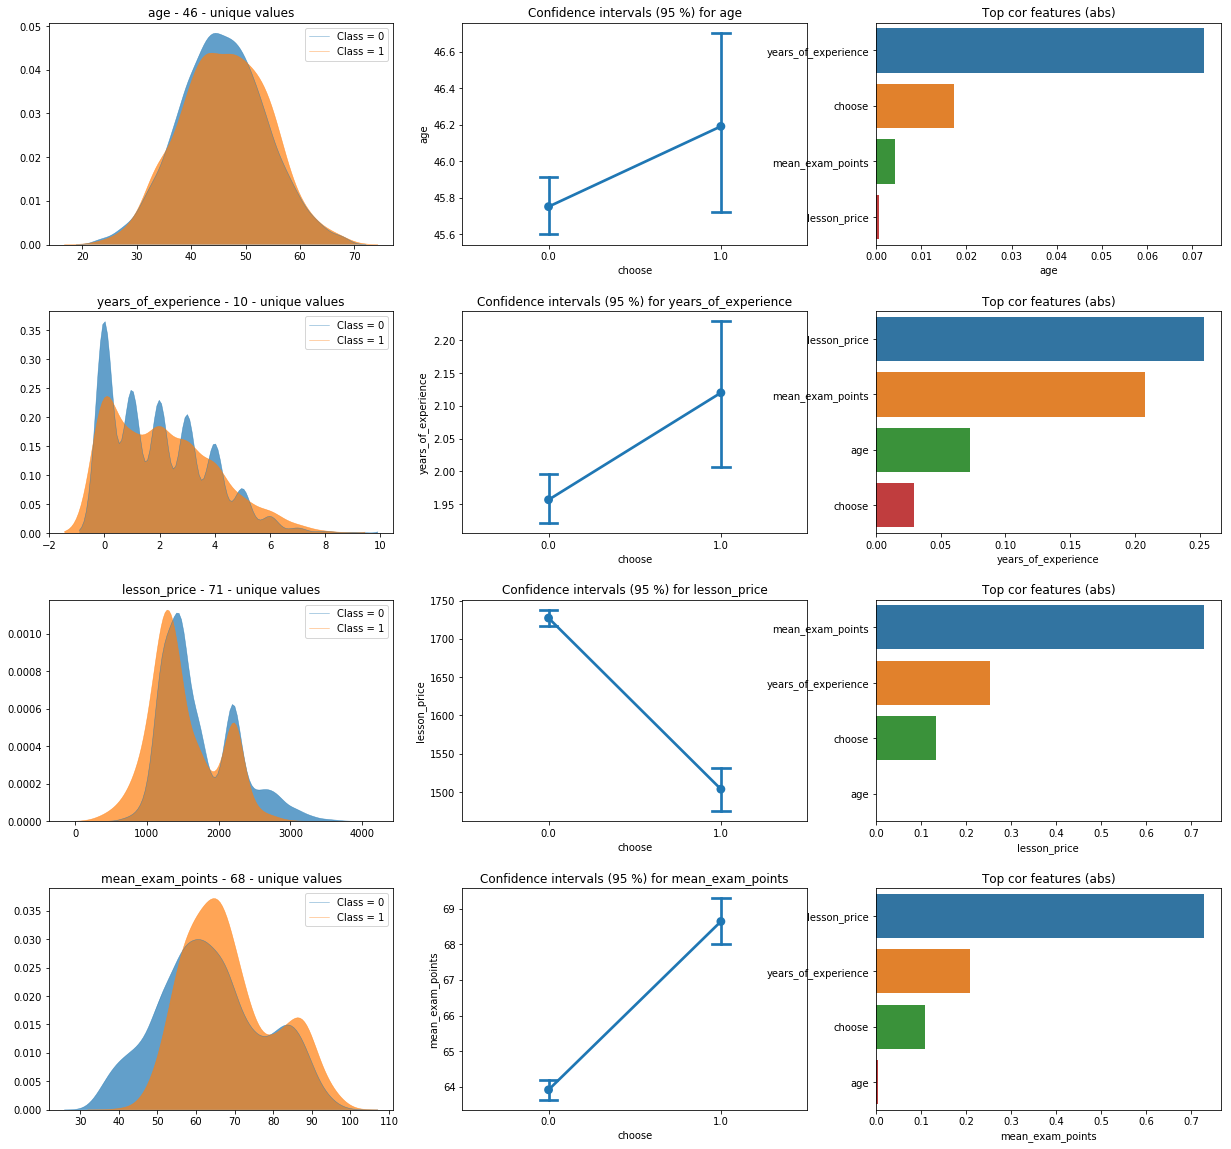

In [20]:
# Визуальный анализ распределения данных
#1) Вывод плотности распределения, 
#2) оценка среднего значения с уровнем значимости 0.05
#3) Скорелированные факторы
col_lst = ['age', 'years_of_experience', 'lesson_price', 'mean_exam_points', TARGET_NAME]
distribution_comparison_by_target_class(df[col_lst].astype('float64'), TARGET_NAME)

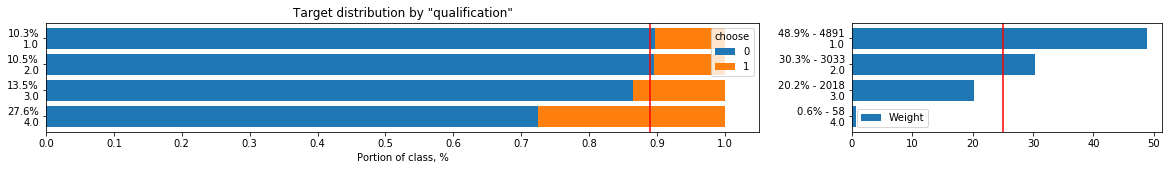

In [21]:
#Визуальная роверка разделения классов по категриямь для категориальных данных
categorization_comparison_by_target_class(df, TARGET_NAME, 'qualification', sort_by='weight')

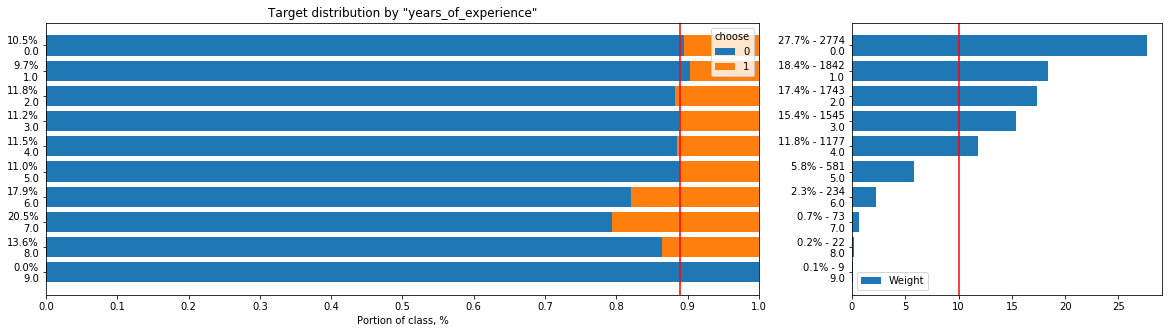

In [22]:
#Визуальная роверка разделения классов по категриямь для категориальных данных
categorization_comparison_by_target_class(df, TARGET_NAME, 'years_of_experience', sort_by='weight')

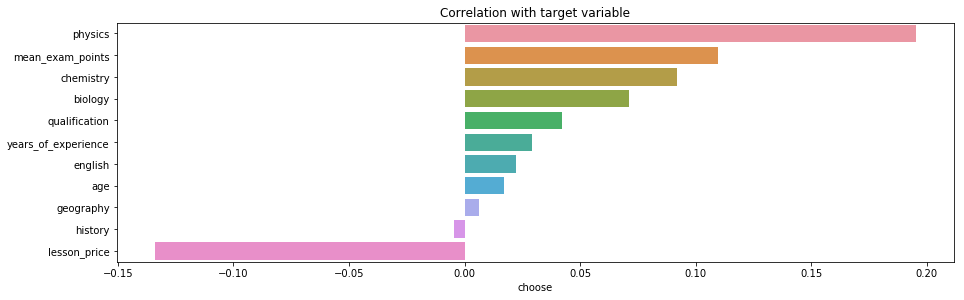

In [23]:
#Кореляция факторов с целевой переменной
cor = df.corr().iloc[:-1,-1].sort_values(ascending=False)

plt.figure(figsize=(15, cor.shape[0] * 0.4))
sns.barplot(x=cor, y=cor.index)
plt.title('Correlation with target variable')
plt.show();


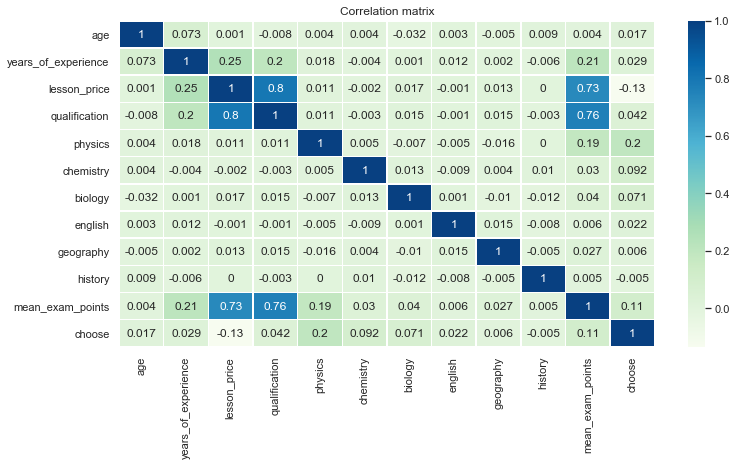

In [25]:
#Матрица Корреляции факторов
heatmap(df)

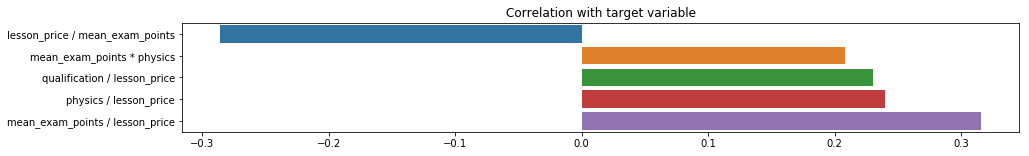

In [24]:
#Вывод наиболее скоррелированных с целевой переменной комбинаций признаков (умножение, деление) 
df1, df1_test = feature_generation(df, df_test, TARGET_NAME, lo_limit=-0.2, hi_limit = 0.2, plot_cor=True)

# Создание и валидация моделей

In [26]:
%%time

# подготовка моделей
mnk = mnk_model(prediction_type='classification', L2=0.1, L1=0.1)
rfm = RandomForest(model_type='classification', n_estimators=100, min_data_in_leaf=40, max_depth=12,random_state=42, split_points=10)

models = {'mnk': mnk, 'rfm':rfm}

# Расчет показателей модели для случая с базовой обработкой данных (метрики лучше)
df_result, df_test_result, model_list = check_models(df=df,
                                                   df_test=df_test,
                                                   TARGET_NAME=TARGET_NAME,
                                                   models = models,
                                                   target_class_ratio=0.50,
                                                   random_state=42,
                                                   SKF_splits=5,
                                                   fold_report=True,
                                                   train_report=False,
                                                   data_pr=True,
                                                   scaler_type='std',
                                                   model_type='classification')


FOLD 1 REPORT
Model                   f1 score           Recall       Precission          ROC AUC
mnk_1_valid               0.4194           0.8009           0.2841           0.8632
rfm_1_valid               0.4039           0.7421           0.2775           0.8298

FOLD 2 REPORT
Model                   f1 score           Recall       Precission          ROC AUC
mnk_2_valid               0.4255           0.8009           0.2897           0.8563
rfm_2_valid               0.4277           0.7692           0.2962           0.8273

FOLD 3 REPORT
Model                   f1 score           Recall       Precission          ROC AUC
mnk_3_valid               0.4208           0.8054           0.2848           0.8646
rfm_3_valid               0.4005            0.724           0.2768           0.8214

FOLD 4 REPORT
Model                   f1 score           Recall       Precission          ROC AUC
mnk_4_valid               0.4159           0.8054           0.2803           0.8499
rfm_4_valid     

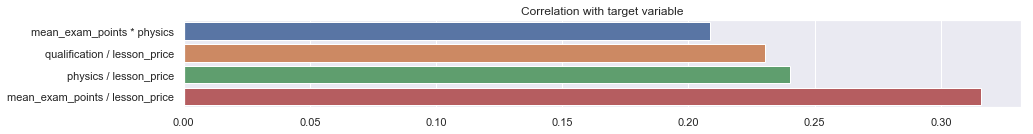


FINAL REPORT (5 folds AVG)
Model                   f1 score           Recall       Precission          ROC AUC
mnk                       0.4159           0.7926           0.2819           0.8553
rfm                       0.4193           0.7475           0.2914           0.8423
MIX RESULT                   nan              0.0              nan           0.8555
Wall time: 14min 24s


In [27]:
%%time

# подготовка моделей
mnk = mnk_model(prediction_type='classification', L2=0.1, L1=0.1)
rfm = RandomForest(model_type='classification', n_estimators=100, min_data_in_leaf=40, max_depth=12,random_state=42, split_points=10)

models = {'mnk': mnk, 'rfm':rfm}

#Добавление к исходному массиву наиболее скоррелированного признака - улучшает качество модели
df1, df1_test = feature_generation(df, df_test, TARGET_NAME, lo_limit=-0.3, hi_limit = 0.2, plot_cor=True, powers=[])

# Расчет показателей модели для случая с дополнительными переменными (метрики лучше)
df1_result, df1_test_result, model_list_1 = check_models(df=df1,
                                                   df_test=df1_test,
                                                   TARGET_NAME=TARGET_NAME,
                                                   models = models,
                                                   target_class_ratio=0.50,
                                                   random_state=42,
                                                   SKF_splits=5,
                                                   fold_report=False,
                                                   train_report=False,
                                                   data_pr=True,
                                                   scaler_type='std',
                                                   model_type='classification')

In [ ]:
df1_test_result

# Вывод предсказний в файл

In [ ]:
# Список столбоц в отчете df_test_result которые необходимо вывести в качестве предсказания
predict_proba_cols = [2 + i*2 for i in range(int((df1_test_result.shape[1] - 1) / 2))]

# Расчет усредненного предсказания вероятности по всем моделям
y_test_pred_proba = np.sum(df1_test_result.iloc[:, predict_proba_cols], axis=1) / len(predict_proba_cols)

pd.DataFrame({'Id': df1_test_result['index'],
              TARGET_NAME: y_test_pred_proba}).to_csv(sub_repot_path, index=False)

print('\nЗапись в файл:', sub_repot_path, '\n')